# Neural Networks

This notebook showcases the neural network surrogate modelling capabilities within `sumomo`.

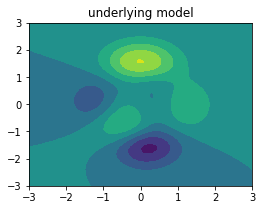

In [2]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import numpy as np

from sumomo import api
from utils import peaks, plot_peaks, plot_model, plot_activation


plot_peaks()

In [3]:
api.initialise(500, [(-3.0, 3.0), (-3.0, 3.0)], 1, 'lhs')
for i in range(api.x.shape[0]):
    api.y[i] = peaks(api.x[i])

api.split()
api.scale()

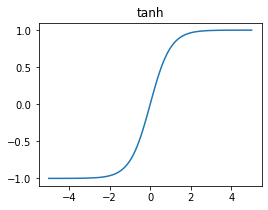

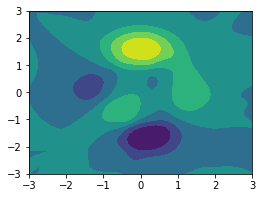

In [4]:
api.init_regressor('nn', hidden_layers=[10, 10], activation='tanh')
api.regressor.fit(api.x_train_, api.y_train_)

plot_activation('tanh')
plot_model(api)

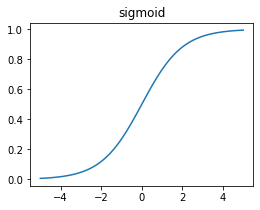

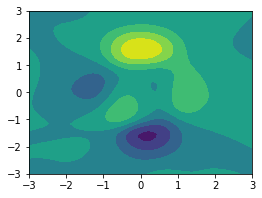

In [5]:
api.init_regressor('nn', hidden_layers=[10, 10], activation='sigmoid')
api.regressor.fit(api.x_train_, api.y_train_)

plot_activation('sigmoid')
plot_model(api)

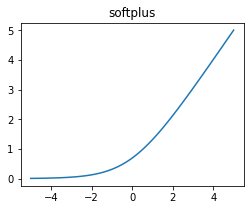

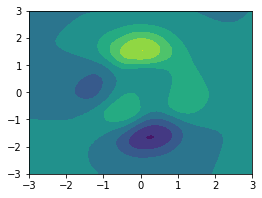

In [6]:
api.init_regressor('nn', hidden_layers=[10, 10], activation='softplus')
api.regressor.fit(api.x_train_, api.y_train_)

plot_activation('softplus')
plot_model(api)

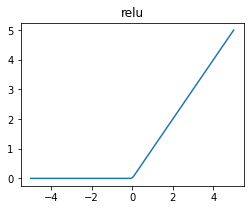

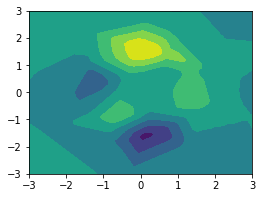

In [7]:
api.init_regressor('nn', hidden_layers=[10, 10], activation='relu')
api.regressor.fit(api.x_train_, api.y_train_)

plot_activation('relu')
plot_model(api)

In [8]:
mse = api.test('mse')
rmse = api.test('rmse')
print(mse)
print(rmse)

0.0287547630698445
0.1695722945231458


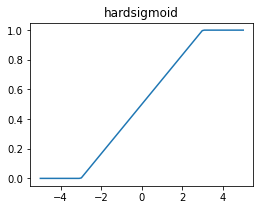

In [9]:
plot_activation('hardsigmoid')